In [49]:
import json
import numpy as np
import matplotlib.pyplot as plt
import scipy
from scipy.interpolate import CubicSpline

In [50]:
# Teste importar Json e plotagem
with open('interlagos.json', 'r') as f:
    data = json.load(f)
pontos = np.array(data['Interlagos']['original'])
x = pontos[:, 0]
y = -pontos[:, 1]

#plt.figure(figsize=(20, 12))
#plt.plot(x ,y, 'k-', label="Circuito Original", linewidth=1)
#plt.scatter(x, y, color='red', s=30)
#plt.title("Circuito de Interlagos")
#plt.xlabel("Coordenada X")
#plt.ylabel("Coordenada Y")
#plt.legend()
#plt.grid(True)
#plt.gca().set_aspect('equal')
#plt.show()

In [51]:
with open('interlagos.json', 'r') as f:
    data = json.load(f)
pontos = np.array(data['Interlagos']['original'])

# Parametros
t = np.linspace(0, 1, len(pontos))
cs_x = CubicSpline(t, pontos[:, 0], bc_type='periodic')
cs_y = CubicSpline(t, -pontos[:, 1], bc_type='periodic')

# Suavizar os pontos
t_smooth = np.linspace(0, 1, 500)
x_center = cs_x(t_smooth)
y_center = cs_y(t_smooth)

# Calculo de vetores para limites da pista
dx = cs_x.derivative(1)(t_smooth)
dy = cs_y.derivative(1)(t_smooth)
normals = np.array([-dy,dx]).T
normals = normals / np.linalg.norm(normals, axis=1)[:, np.newaxis]

# Definição de largura da pista
width = 6
x_inner = x_center - width * normals[:, 0]
y_inner = y_center - width * normals[:, 1]
x_outer = x_center + width * normals[:, 0]
y_outer = y_center + width * normals[:, 1]

#plt.figure(figsize=(20, 12))
##plt.plot(x_center ,y_center, 'k-', label="Circuito Original", alpha = 1)
#plt.plot(x_inner, y_inner, 'red', label='limite interno')
#plt.plot(x_outer, y_outer, 'red', label='limite externo')
##plt.fill_betweenx(y_outer, x_inner, color='green', alpha=1)
#plt.title("Circuito de Interlagos")
##plt.xlabel("Coordenada X")
##plt.ylabel("Coordenada Y")
##plt.legend()
#plt.grid(True)
#plt.gca().set_aspect('equal')
#plt.show()

In [52]:
def calc_comprimento():
    comprimento = 0
    for i in range(1, len(t_smooth)):
        dx = x_center[i] - x_center[i-1]
        dy = y_center[i] - y_center[i-1]
        comprimento += np.sqrt(dx**2 + dy**2)
    return comprimento

comp_atual = calc_comprimento()
print(comp_atual, 'm')

3181.0622750613265 m


In [53]:
escala = 4309 / comp_atual

print(escala)
print(f"Fator de escala: {escala:.4f}")

1.3545789511200086
Fator de escala: 1.3546


In [54]:
pontos *= escala

cs_x = CubicSpline(t, pontos[:, 0], bc_type='periodic')
cs_y = CubicSpline(t, -pontos[:, 1], bc_type='periodic')

x_center = cs_x(t_smooth)
y_center = cs_y(t_smooth)
dx = cs_x.derivative(1)(t_smooth)
dy = cs_y.derivative(1)(t_smooth)
normals = np.array([-dy,dx]).T
normals = normals / np.linalg.norm(normals, axis=1)[:, np.newaxis]

x_inner = x_center - width * normals[:, 0]
y_inner = y_center - width * normals[:, 1]
x_outer = x_center + width * normals[:, 0]
y_outer = y_center + width * normals[:, 1]

In [55]:
compr_final = calc_comprimento()
print(compr_final)

4309.0


In [56]:
mu = 1.7             # Coeficiente de atrito
g = 9.81             # gravidade m/s²
mass = 950           # kg
power = 950 * 745.7  # converção HP para Watts
drag_coef = 0.7      # coeficiente de arrasto
frontal_area = 1.5   # m²
rho = 1.225          # densidade do ar
a = 13.89            # aceleração m/s²
dece = 33.3          # desaceleração m/s² 
mu_ef = dece / g     # coef. atrito
downforce160 =  750  # kd downforce a 160

# Calculos/funções físicos
def max_speed_in_curve(radius):
    return np.sqrt(mu * g * radius)

def max_acceleration(v):
    if v < 1e-6:
        return min(power / mass, mu * g)
    drag = 0.5 * rho * drag_coef * frontal_area * v**2
    available_power = min(power, power * (v/50))
    return (available_power - drag) / (mass * v)

def downforce(v_ms):
    return downforce160 * g * (v_ms / (160/3.6))**2

def arrasto (v_ms):
    return 0.5 * rho * drag_coef * frontal_area * v_ms**2

def aceleracao_max(am):
    drag = arrasto(v_ms)
    potencia_efetiva = min(power, power*(am/50))
    return (potencia_efetiva - drag) / (mass * am)

def max_dece(v_ms):
    df = downforce(v_ms)
    return mu_ef * (g + df / mass)

def calc_distancia(x1, y1, x2, y2):
    return np.sqrt((x2-x1)**2 + (y2-y1)**2)



In [57]:
#Calculo raio de curvatura (curvas)
ddx = cs_x.derivative(2)(t_smooth)
ddy = cs_y.derivative(2)(t_smooth)
curvature = (dx*ddy - dy*ddx) / (dx**2 + dy**2)**1.5
radius = np.abs(1/curvature)

In [58]:
# Simulação de volta


n_points = len(t_smooth)
velocities = np.zeros(n_points)
velocities[0] = 0 #velocidade inicial igual a 0 (alteral em m/s²)
distancias = np.zeros(n_points)

for i in range(1, n_points):
    distancias[i] = calc_distancia(x_center[i-1], y_center[i-1], x_center[i], y_center[i]) 


for i in range(1, n_points):
    v_max_curve = max_speed_in_curve(radius[i])

    if radius[i] > 300:    #Verificar se é reta ou curva, raio > 300 = reta
        a = max_acceleration(velocities[i-1])
        velocities[i] = min(velocities[i-1] + a * 0.1, 83.33)

    else:        #Frenagem progressiva para curva
        if velocities[i-1] > v_max_curve:
            dece = max_dece(velocities[i-1])
            dt = distancias[1] / velocities[i-1] if velocities[i-1] > 0 else 0.1
            velocities[i] = max(velocities[i-1] - dece * dt, v_max_curve)
        else:
            velocities[i] = v_max_curve

In [59]:
from scipy.optimize import minimize

def objective(offsets):   #Calcula tempo total da volta
    total_time = 0
    prev_v = velocities [0]

    for i in range(n_points):   #Posição na pista
        offset = offsets[i]
        x = x_center[i] + offset * normals[i, 0]
        y = y_center[i] + offset * normals[i, 1]

        if i > 0:  #Distância entre pontos
            ds = calc_distancia(x_prev, y_prev, x, y)
            total_time += ds / ((prev_v + velocities[i]) / 2)    #tempo médio

        x_prev, y_prev = x, y
        prev_v = velocities[i]
    return total_time

bounds = [(-width, width) for _ in range(n_points)]  #Restrição para se manter na pista

#Otimização sugerida, só confiei
initial_offsets = np.zeros(n_points)
result = minimize(objective, initial_offsets, bounds=bounds, method='SLSQP')
optimal_offsets = result.x

In [76]:
def calcular_tempo_volta(velocidade, distancias):
    tempo = 0
    for i in range(1, len(velocidade)):
        if velocidade[i] > 0:
            tempo += distancias[i] / velocidade[i]
    return tempo

tempo_total = calcular_tempo_volta(velocities, distancias)
print(tempo_total)

95.8873044931599


In [103]:
tempo_min = int(tempo_total // 60)
tempo_seg = int(tempo_total % 60)
tempo = f'{tempo_min}:{tempo_seg:02d}'

print(tempo)

1:35


In [64]:
## Visualização de resultados
# Melhor trajetória
x_optimal = x_center + optimal_offsets * normals[:, 0]
y_optimal = y_center + optimal_offsets * normals[:, 1]

#Plot
#plt.figure(figsize=(20,10))
#plt.plot(x_center, y_center, 'k--', alpha= 0.3, label = 'linha central')
#plt.plot(x_inner, y_inner, 'r-', alpha=0.3, label='limites da pista')
#plt.plot(x_outer, y_outer, 'r-', alpha=0.3)
#plt.plot(x_optimal, y_optimal, 'b-', linewidth=2, label='trajetória ótima')
#plt.legend()
#plt.gca().set_aspect('equal')
##plt.title()
#plt.show()

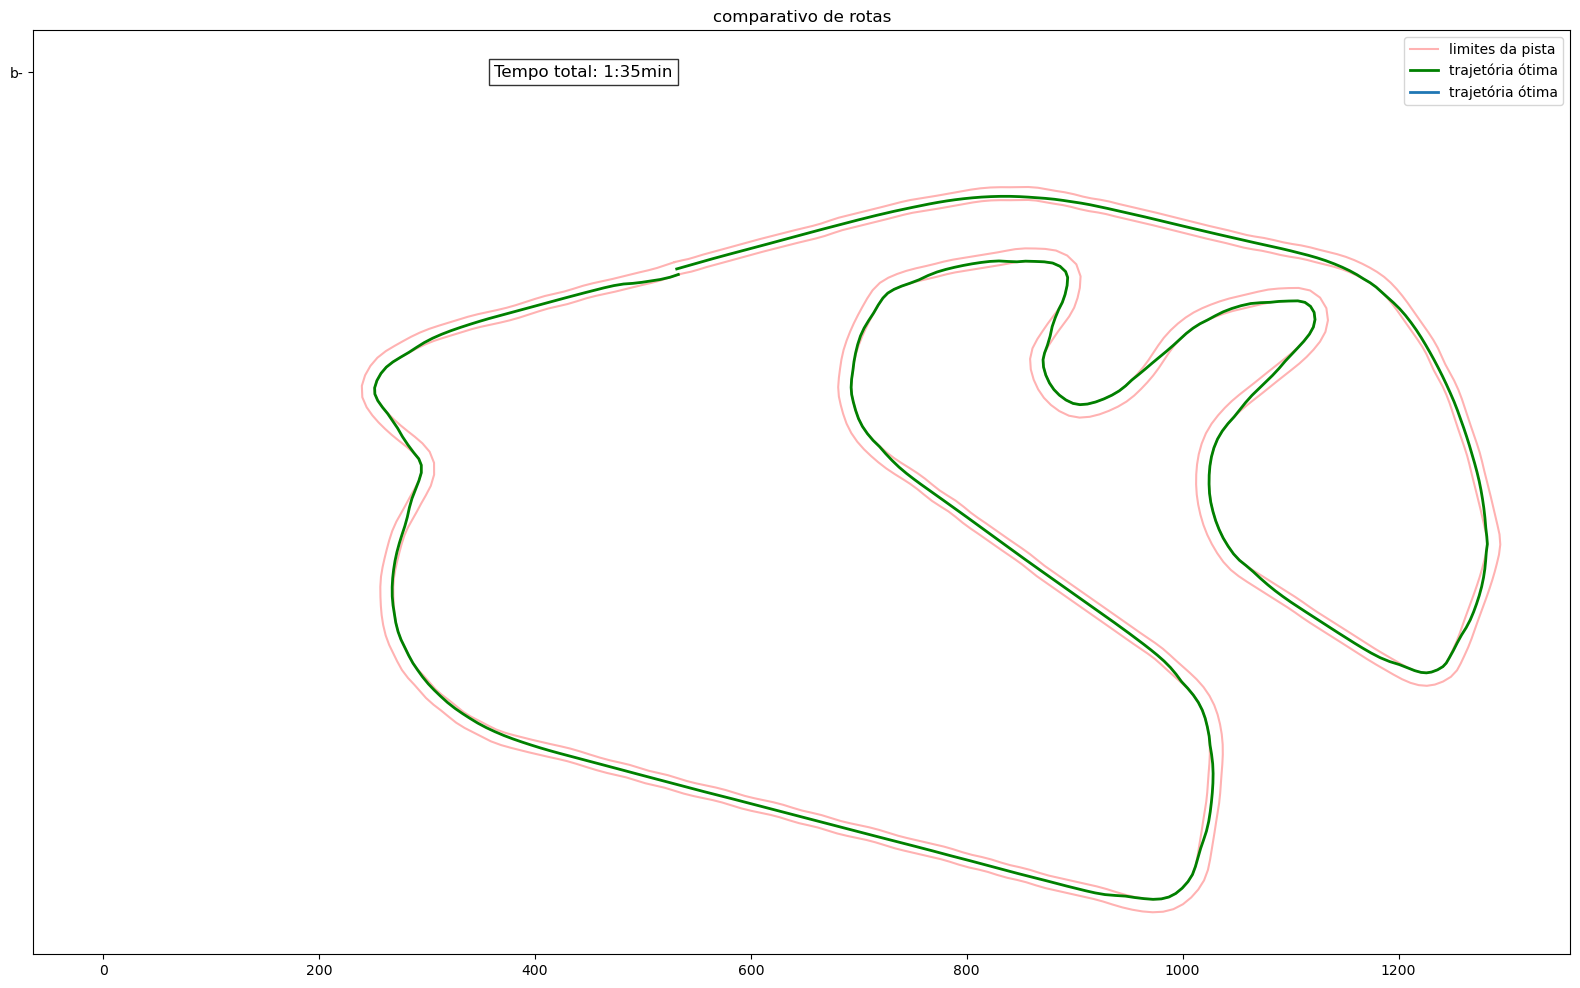

In [119]:
# Trajetória média
medium_offsets = optimal_offsets * 0.25
x_medium = x_center + medium_offsets * normals[:, 0]
y_medium = y_center + medium_offsets * normals[:, 1]

#Trajetória péssima
bad_offsets = np.where(optimal_offsets > 10, width*0.9, -width*0.9)
x_bad = x_center + bad_offsets * normals[:, 0]
y_bad = y_center + bad_offsets * normals[:, 0]

##Plot
plt.figure(figsize=(20, 12))
plt.plot(x_inner, y_inner, 'r-', alpha=0.3, label='limites da pista')
plt.plot(x_outer, y_outer, 'r-', alpha=0.3)
plt.plot(x_optimal, y_optimal, 'green', 'b-',  linewidth=2, label='trajetória ótima')
#plt.plot(x_medium, y_medium, 'b-', linewidth=2, label='trajetória média')
#plt.plot(x_bad, y_bad, 'red', 'b-', linewidth=2, label='trajetória ruim')
plt.text(
    0.3, 0.95, 
    f"Tempo total: {tempo}min",
    transform=plt.gca().transAxes,
    fontsize=12,
    bbox=dict(facecolor='white', alpha=0.8)
)
plt.legend()
plt.gca().set_aspect('equal')
plt.title('comparativo de rotas')
plt.show()

In [33]:
#plt.figure(figsize=(12, 6))
#plt.plot(velocities * 3.6)
#plt.xlabel('ponto da pista')
#plt.ylabel('velocidade')
#plt.title('Perfil de velocidade')
#plt.grid(True)
#plt.show

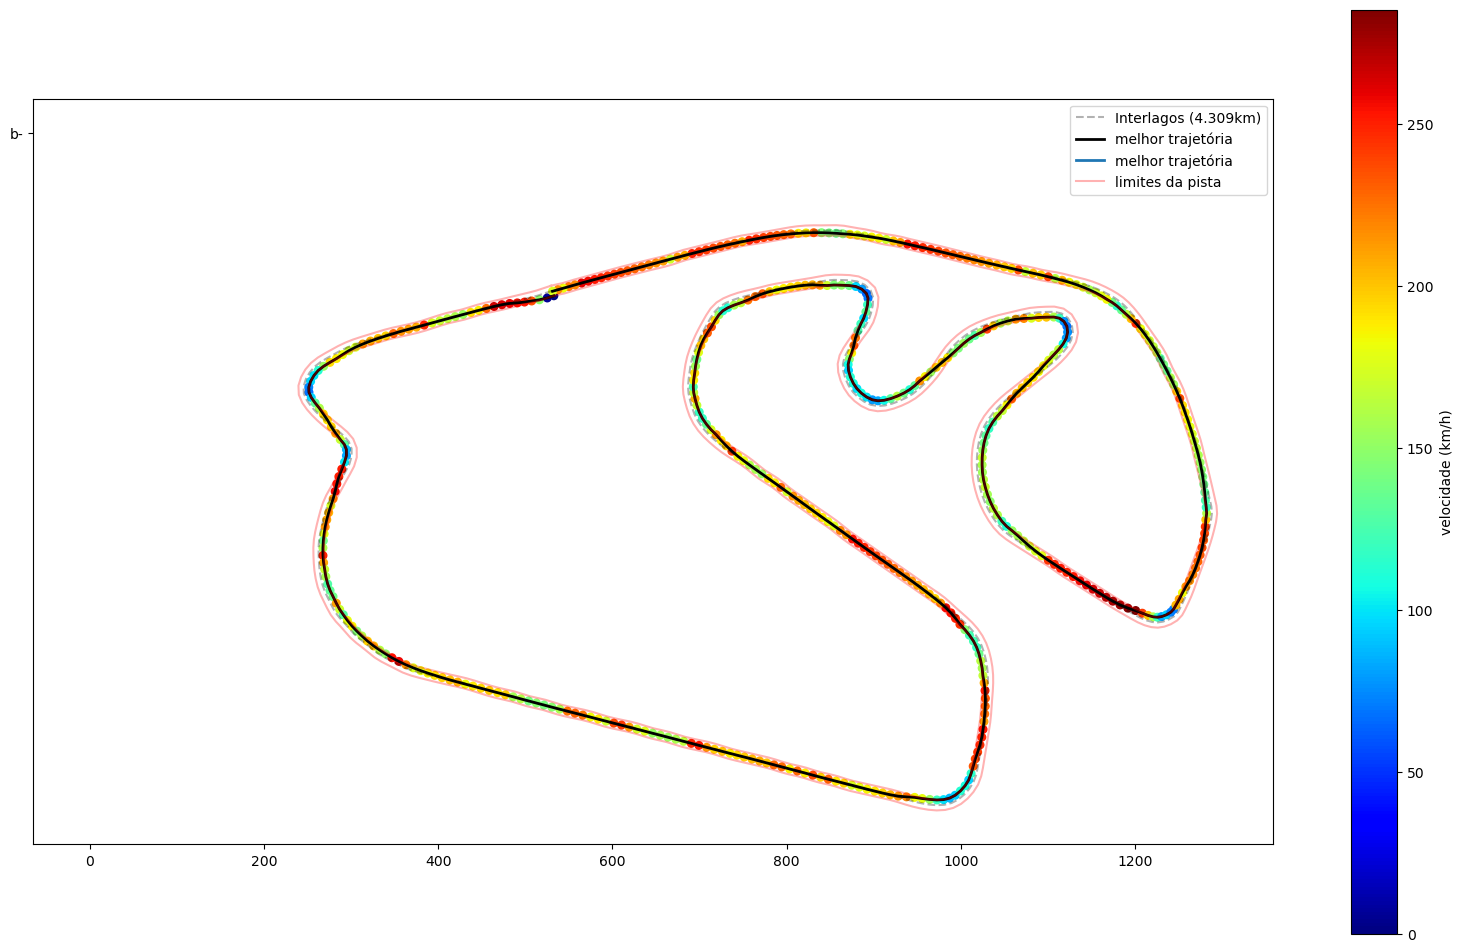

In [102]:
plt.figure(figsize=(20,12))
plt.plot(x_center, y_center, 'k--', alpha=0.3, label=f'Interlagos ({compr_final/1000:.3f}km)')
plt.plot(x_optimal,y_optimal, 'black', 'b-', linewidth=2, label='melhor trajetória')
plt.plot(x_inner, y_inner, 'r-', alpha=0.3, label='limites da pista')
plt.plot(x_outer, y_outer, 'r-', alpha=0.3)
plt.scatter(x_optimal[::1], y_optimal[::1], c=velocities[::1]*3.6,cmap='jet', s=30)
plt.colorbar(label='velocidade (km/h)')
plt.legend()
plt.gca().set_aspect('equal')
plt.show()

In [123]:
import matplotlib.animation as animation
from matplotlib.patches import Circle

fig, ax = plt.subplots(figsize=(12, 8))
ax.set_aspect('equal')
plt.title('Simulação da volta')

ax.plot(x_center, y_center, 'k--', alpha=0.3, label='linha central')
ax.plot(x_inner, y_inner, 'gray', alpha=0.5)
ax.plot(x_outer, y_outer, 'gray', alpha=0.5)

bolinha = Circle((0, 0), radius=3  , color='red', zorder=10)
ax.add_patch(bolinha)

text_tempo = ax.text(0.05, 0.95, "Tempo: 0:00", transform=ax.transAxes,
                     fontsize=12, bbox=dict(facecolor='white', alpha=0.8))

def animate(i):
    idx = i*10 % len(x_optimal)
    bolinha.center = (x_optimal[idx], y_optimal[idx])

    tempo_decorrido = i / 60
    minutos = int(tempo_decorrido // 60)
    segundos = int(tempo_decorrido % 60)
    text_tempo.set_text(f"tempo: {minutos}:{segundos:02d}")

    velocidade_atual = velocities[idx] * 3.6
    cor = plt.cm.jet((velocidade_atual - np.min(velocities*3.6)) /
                    (np.max(velocities*3.6) - np.min(velocities*3.6)))
    bolinha.set_color(cor)

    return bolinha, text_tempo

ani = animation.FuncAnimation(
    fig = fig,
    func = animate,
    frames = len(x_optimal)//10,
    interval = 16,
    blit = True
)

plt.legend()
plt.close()

from IPython.display import HTML
HTML(ani.to_jshtml())
